#Assignment 1: Model Predictive Control of a N-link Manipulator

Please refer to the [assignment writeup](https://docs.google.com/document/d/10MimvEV9Gye-0SRv5a9cSg6ad9OvMkkofRUgNaMeJao/edit?usp=sharing)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, Image
rc('animation', html='jshtml')

# Arm kinematics and visualization 

When you build a robot arm, the first thing you want to do is to write down all the numbers you need to describe it. For our planar N-link arm, it boils down to 4 numbers:
* How many links does the arm have?
* How long is each link?
* What is the mass of each link?
* Where is the base of the arm located in the world?

We have provided some reasonable numbers, but feel free to experiment with different parameters.

In [2]:
# Parameters of the arm
num_links = 2
length_m = 0.5 * np.ones(num_links) 
mass_kg = 1 * np.ones(num_links) 
base_se2 = np.array([0.0, 0.0, 0.0]) # Base of the arm in world frame

Let’s visualize the arm in different configurations. the arm when in different *configurations*. The *configuration* of the arm is specified by a vector of joint angles. 
Given these joint angles, one can proceed link by link and compute the position of the link in the world. This computation is referred to as the [forward kinematics](https://en.wikipedia.org/wiki/Forward_kinematics). Once we have the link positions, we can visualize the arm easily.

We have provided some code for both forward kinematics and arm visualization. Try visualizing different configurations so you get some intuition about forward kinematics!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


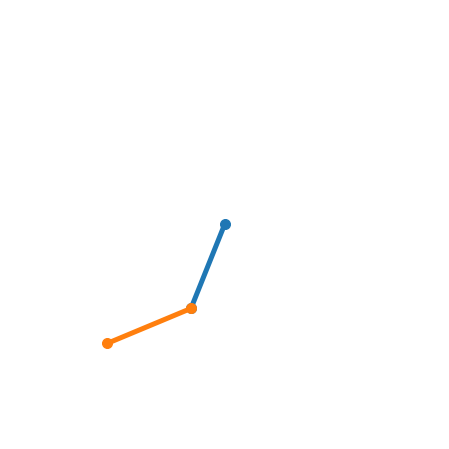

In [3]:
def forward_kinematics(theta, length_m, base_se2):
  """ Compute the location of each link in the arm given joint angles
  Args:
    theta: (N,1) array of joint angles 
    length_m: (N,1) array of arm lengths
    base_se2: (3,1) array of base frame (x,y,theta)
  Returns:
    [N+1,2] array of x,y location of each link
  """
  Tmatrix = lambda se2:  np.array([(np.cos(se2[2]), -np.sin(se2[2]), se2[0]), 
                            (np.sin(se2[2]), np.cos(se2[2]), se2[1]), 
                            (0., 0., 1.)])
  num_links = theta.shape[0]
  world_link = Tmatrix(base_se2)

  link_pos = world_link[0:2,-1]
  for idx in range(0, num_links):
    # First rotate
    world_link = world_link @ Tmatrix(np.array([0, 0, theta[idx]]))
    # Then traslate
    world_link = world_link @ Tmatrix(np.array([length_m[idx], 0, 0]))
    link_pos = np.vstack((link_pos, world_link[0:2,-1] ))
  return link_pos

def plot_arm(theta, length_m, base_se2):
  """ Plots arm given joint angles
  Args:
    theta: (N,1) array of joint angles 
    length_m: (N,1) array of arm lengths
    base_se2: (3,1) array of base frame (x,y,theta)
  """
  link_pos = forward_kinematics(theta, length_m, base_se2)
  for idx in range(1, link_pos.shape[0]):
    plt.plot(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1], '-o', linewidth=5, markersize=10)
  

# Let's try visualizing some arm configurations
fig = plt.figure(figsize=(8, 8))
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.axis('off')
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

theta = np.random.randn(num_links, 1)
plot_arm(theta, length_m, base_se2)
fig.show()

Now let's animate the arm. This will come in handy when we develop controllers that optimize the motion of the arm. We can also optionally stick a marker to the end-effector to see a trace of the arm.

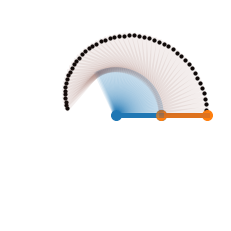

In [4]:
def animate_arm(x_traj, draw_ee=False, draw_trace=False):
  """ Animate the arm as it follows a joint angle trajectory
  Args:
    theta_traj: List of (N,1) joint angles
    draw_ee: If true, plot a trace of the end effector as it moves 
  Returns:
    animate object
  """
  fig = plt.figure()
  plt.xlim([-1.2, 1.2])
  plt.ylim([-1.2, 1.2])
  plt.axis('off')
  plt.grid()
  plt.gca().set_aspect('equal', adjustable='box')

  arm_lines = []
  for idx in range(0, length_m.shape[0]):
      arm_lines += plt.plot([0, 0], [0, 0], '-o', linewidth=5, markersize=10)

  def update_arm(i):
    theta = x_traj[i][:2]
    link_pos = forward_kinematics(theta, length_m, base_se2)
    if draw_ee: 
      plt.scatter(link_pos[-1,0], link_pos[-1,1], s=10, color='k')
    if draw_trace:
      colors = plt.cm.tab10(np.linspace(0,1,link_pos.shape[0]))
      for idx in range(1, link_pos.shape[0]):
        plt.plot(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1], linewidth=5, alpha=0.1, color=colors[idx-1])
    for idx in range(1, link_pos.shape[0]):
      arm_lines[idx-1].set_data(link_pos[idx-1:idx+1,0], link_pos[idx-1:idx+1,1])

  anim = FuncAnimation(fig, update_arm, frames=len(x_traj), interval=30, blit=False, repeat=False)
  return anim

# Let's animate the arm moving from an initial to a final configuration
x_0 = np.array([0., 0., 0., 0.])
x_f = np.array([2., 2., 0., 0.])
theta_traj = list(np.linspace(x_0, x_f, num=50, endpoint=True))
animate_arm(theta_traj, draw_ee=True, draw_trace=True)

# Deriving Dynamics of a 2-link Manipulator

Let’s begin by modeling our N-link manipulator. We will stick to N=2 to keep things simple (more on N>2 later). 

Derive the dynamics of a N=2 link arm. The dynamics model is a function that takes the current state, current set of control torques and returns the next state. An elegant way to derive the dynamics is to write down the Euler Lagrange equations, as shown in [Lynch & Park, Pg 273.](http://hades.mech.northwestern.edu/images/7/7f/MR.pdf)

In [ ]:
def manipulator_dynamics(x, u, dt=0.1):
  """ Compute the dynamics of a manipulator
  Args:
    x: (2N,1) array of arm state (joint angle, joint velocity)
    u: (N,1) array of joint torques
    dt: discrete time interval
  Returns:
    The next state 
  """

# The Linear Quadratic Regulator (LQR)

It’s now time to code up your first decision making algorithm – LQR or value-iteration-for-linear-dynamics-and-quadratic-costs! Let’s regulate the arm around the rest position Θ = (0,0).

A core component of LQR is linearizing dynamics and quadracizing the cost about some reference point. Instead of doing this by hand, you can use autograd. The following code snippet shows you how to compute jacobians to get first and second derivatives. 

In [ ]:
import autograd.numpy as np
from autograd import grad, jacobian

def get_jacobians(dynamics_fun, cost_fun):
  """ Compute jacobians of dynamics and cost function
  Args:
    dynamics_fun: The dynamics function
    cost_fun: The cost function
  Returns:
    A tuple of first and second derivatives of dynamics and cost function
  """
  dyn_x = jacobian(dynamics_fun, 0)
  dyn_u = jacobian(dynamics_fun, 1)
  cost_x = jacobian(cost_fun, 0)
  cost_xx = jacobian(cost_x, 0)
  cost_u = jacobian(cost_fun, 1)
  cost_uu = jacobian(cost_u, 1)
  return dyn_x, dyn_u, cost_x, cost_xx, cost_u, cost_uu

In [ ]:
def regulator_cost(x, u, theta_ref):
  """ Computes quadratic cost of state, action pair
  Args:
    x: Current state
    u: Current control action
    theta_ref: The reference angle to regulate the arm around
  Returns:
    Scalar cost
  """

def lqr_input_matrices(x_ref, dyn_x, dyn_u, cost_xx, cost_uu):
  """ Compute A, B, Q, R matrices
  Args:
    x_ref: State around which to linearize around
    dyn_x: First derivative of dynamics wrt to x
    dyn_u: First derivative of dynamics wrt to u
    cost_xx: Second derivative of dynamics wrt to x
    cost_uu: Second derivative of dynamics wrt to u
  Returns:
    A, B, Q, R matrices
  """

def lqr_gains(A, B, Q, R, H):
  """ Run value iteration and compute V and K matrices for each time step
  Args:
    A: (2N, 2N) dynamics matrix
    B: (2N, N) dynamics matrix 
    Q: (2N, 2N) quadratic cost matrix
    R: (N, N) quadratic cost matrix
    H: Time horizon
  Returns:
    List of K matrices for each timestep
  """

def lqr_forward(x_0, K_list, dynamics_fun):
  """  Start from initial state and iteratively apply K matrices and dynamics 
  to roll out a trajectory
  Args:
    x_0: (2N, 1) initial state
    K_list: List of K matrices for each timestep
    dynamics_fun: The dynamics function
  Returns:
    List of states one for each timestep 
  """
  

In [ ]:
# Apply LQR to regulate the arm starting from an initial state
x_0 = np.array([2.0, 2.0, 0., 0.]) # Initial state
x_ref = np.array([0., 0., 0., 0.]) # State that we are regulating around
H = 100 # Horizon 

dynamics_fun = lambda x, u: manipulator_dynamics(x, u)
cost_fun = lambda x, u: regulator_cost(x, u, x_ref[0:2])

dyn_x, dyn_u, cost_x, cost_xx, cost_u, cost_uu = get_jacobians(dynamics_fun, cost_fun)
A, B, Q, R = lqr_input_matrices(x_ref, dyn_x, dyn_u, cost_xx, cost_uu)
K_list = lqr_gains(A, B, Q, R, H)

x_traj,_ = lqr_forward(x_0, K_list, manipulator_dynamics)
animate_arm(x_traj, draw_trace=True)

# Iterative Linear Quadratic Regulator (iLQR)

We are now going to use iLQR to move the end-effector of the arm to a target position. The key change from the previous LQR problem is that the cost function now looks at the end effector coordinates of the arm, i.e. (ee(t) - ee_goal)^2 where ee(t) is the end effector position.

We recommend the following key steps:

1. **Time-varying LQR:** Update LQR to handle time varying At, Bt, Qt, Rt matrices
2. **Affine LQR:** Since we are linearizing about (xref, uref) and not the origin, we need to account for offset terms in the dynamics. This is best handled by going to homogeneous coordinates where we augment the state x= [x 1].
3. **Change of basis:** Since we have a trajectory  (xref(t), uref(t)) that we are linearizing about, it’s best to change coordinates to work as an offset from (xref(t), uref(t))

In [ ]:
# Code for iLQR

def end_effector_cost(x, u, ee_goal):
    """ Computes cost of state, action pair
  Args:
    x: Current state
    u: Current control action
    ee_goal: The goal 
    theta_ref: The reference angle to regulate the arm around
  Returns:
    Scalar cost
  """

In [ ]:
# Apply iLQR to control end effector about some setpoint
x_0 = np.array([0., 0., 0., 0.])
ee_goal = [0.0, 0.5]
H = 100

dynamics_fun = lambda x, u: manipulator_dynamics(x, u)
cost_fun = lambda x, u: end_effector_cost(x, u, ee_goal)
dyn_x, dyn_u, cost_x, cost_xx, cost_u, cost_uu = get_jacobians(dynamics_fun, cost_fun)

x_opt_traj = ...
animate_arm(x_opt_traj)

# Extra Credit: Choose Your Adventure!
